In [311]:
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set_context("poster")
%pylab inline
FS, FSS, FSSS = (16, 9), (16, 6), (16, 3)

pd.options.display.float_format = '{:,.4f}'.format

Populating the interactive namespace from numpy and matplotlib


<br/><br/><br/>

## Load the data

In [312]:
dp   = lambda date: pd.datetime.strptime(date, '%d%b%Y')
 
data = pd.read_csv('Example Stocks.csv', parse_dates=['date'], date_parser=dp)

data.columns = list( map( lambda x : x.lower(), data.columns ) )
data['asset'] = data['asset'].apply( lambda x : x.title() )


class Stock:
    def __init__( self, permno, color, data=data ):
        self.permno = permno
        self.color  = color
        self.mask   = (data['permno']==permno)
        self.name   = data[self.mask]['asset'].iloc[0]
        
CocaCola     = Stock( 11308, sns.xkcd_rgb['red']  )
Apple        = Stock( 14593, sns.xkcd_rgb['denim blue'] )
PhilipMorris = Stock( 92602, sns.xkcd_rgb['dark grey'] )
Tesla        = Stock( 93436, sns.xkcd_rgb['teal'] )

all_stocks   = [ Apple, CocaCola, PhilipMorris, Tesla ]
stock_colors = [ x.color for x in all_stocks ]

In [313]:
def plot_returns(stocks, data=data):
    
    if type(stocks) == Stock:
        stocks = [stocks]

    fig, ax1 = plt.subplots(1,1, figsize=FS)
    
    for stock in stocks:
        df = data[ data['permno']==stock.permno ]
        df.plot(
            y='ret', x='date', style=':', marker='o', 
            label=stock.name+' monthly returns', 
            ax=ax1, color= stock.color
               )
        
    legend = plt.legend(frameon=True, loc=0)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.ylim([-0.3,0.3])
    #ax1.axhline(0, linestyle=':', color='grey')

<br/><br/><br/>

## Returns

$$ R_t = \frac{p_{t}-p_{t-1}}{p_{t-1}} = \frac{p_{t}}{p_{t-1}} - 1 $$

Usually, we consider dividends as well

$$ R_t = \frac{p_{t}+d_{t}}{p_{t-1}} - 1 $$

## Historical returns data
As an example, I downloaded historical returns of 4 well-known companies quoted in the US equity market, from 2011 to 2015.

Let's see what we have:

In [314]:
data.groupby('asset').head(2)[['asset', 'date', 'prc', 'ret']]

,asset,date,prc,ret
0,Coca Cola,2011-01-31,62.8500,-0.0444
1,Coca Cola,2011-02-28,63.9200,0.0170
60,Apple,2011-01-31,339.3200,0.0520
61,Apple,2011-02-28,353.2100,0.0409
120,Philip Morris,2011-01-31,57.2400,-0.0220
121,Philip Morris,2011-02-28,62.7800,0.0968
180,Tesla Motors,2011-01-31,24.1000,-0.0950
181,Tesla Motors,2011-02-28,23.8900,-0.0087


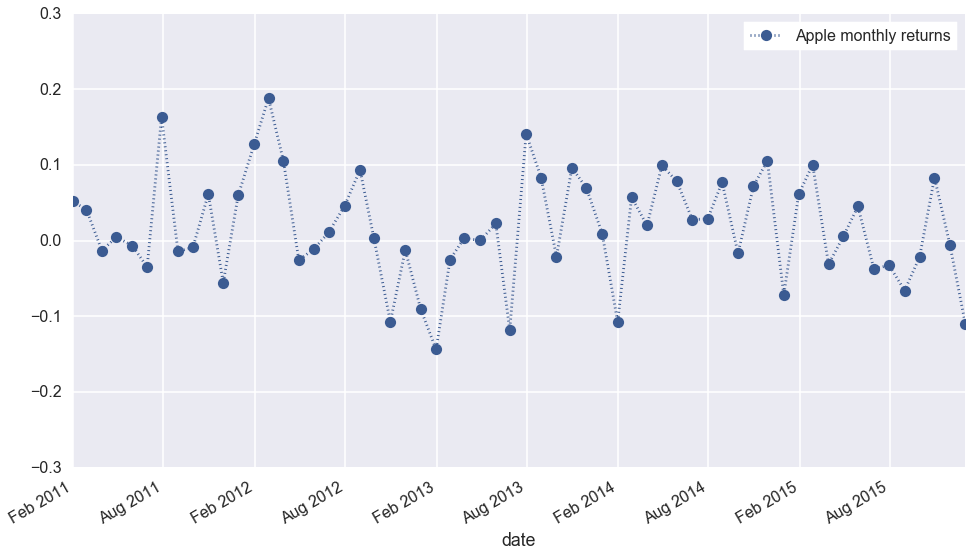

In [282]:
plot_returns( Apple )

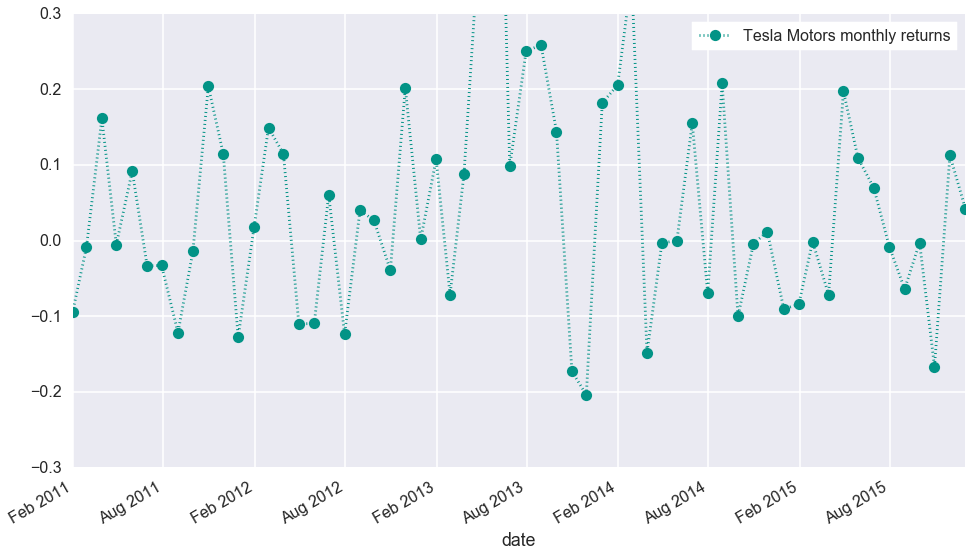

In [283]:
plot_returns( Tesla )

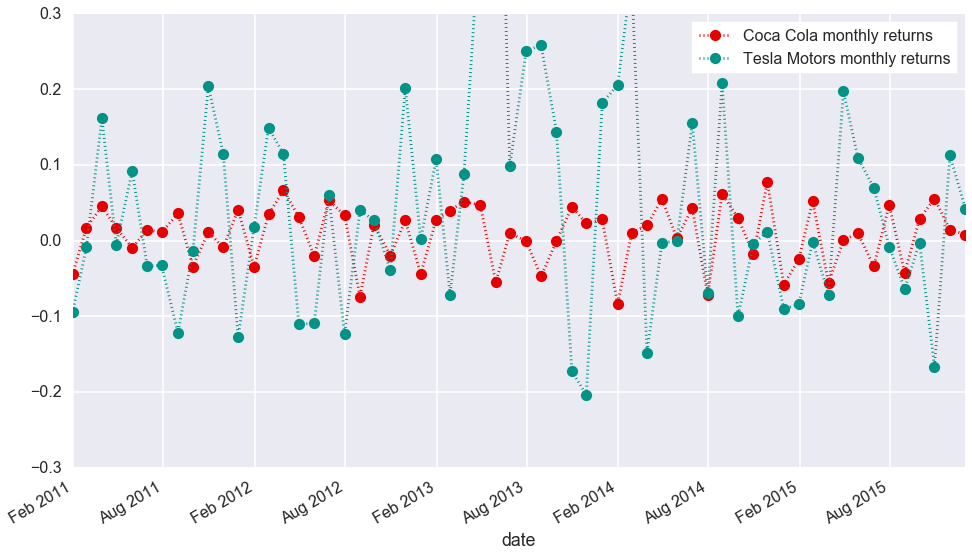

In [284]:
plot_returns( [ CocaCola  ,  Tesla  ] )

<br/><br/><br/>

## Expectation
The **expected value** of a random variable $X$ is defined as

$$ E(X) = \sum_{x} x \cdot P_X(x) $$

where the sum runs over all the possible values that $X$ can take, while $P(x)$ denotes the probability that $X$ takes the values $x$.

**Remember:** $X$ is a random variable, while $E(X)$ is just a number

## Expectation - Properties
- The expectation of a number is just the number itself: 

$$ \quad E(a) = a \quad \forall a \in \mathbb{R} $$

- The expectation operator is linear: if $X$ and $Y$ are random variables and $ a,b,c $ are numbers, then

$$ \quad E(a + bX + cY ) = a + b E(X) + c E(Y) $$

---
**Exercise:** Prove these properties by using the definition of $E(\;)$ and the fact that a number can be seen as a random variable with only one possible realization

## Sample Average
Suppose we have a sample of $n$ realizations $\{ x_1, \dots, x_n \}$ of a random variable $X$. The empirical counterpart of the expectation operator is the **sample average**, defined as

$$ \hat{E}(X) = \frac{1}{n}\sum_{i=1}^n x_i $$

Basically, we are assuming that our sample is drawn from a uniform distribution, meaning that $P_X(x)=\frac{1}{n}$ for every realized value $x$.

## Expected Return
In the case of stock returns, we don't know their probability distributions. 

But we have realizations from historical data, so we can compute the sample average, or **mean**

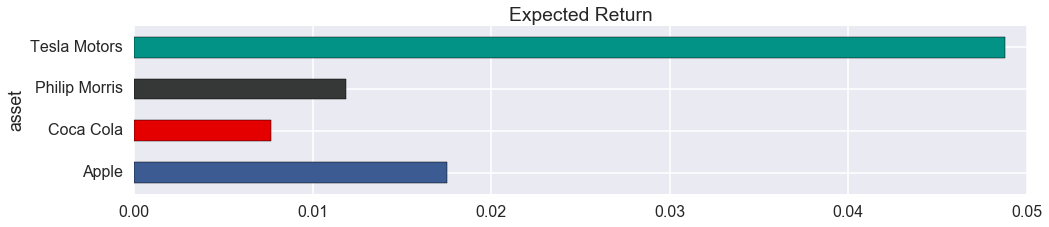

In [285]:
data.groupby('asset')['ret'].mean().plot(kind='barh', figsize=FSSS, color=stock_colors)
_ = plt.title('Expected Return')

In [315]:
def E(ret):
    n = len(ret)
    return ret.sum() / n

data.groupby('asset').agg( { 'ret':[ mean, E ] } )

ret       
                mean      E
asset                      
Apple         0.0175 0.0175
Coca Cola     0.0076 0.0076
Philip Morris 0.0119 0.0119
Tesla Motors  0.0488 0.0488

<br/><br/><br/>

## Variance

The **variance** of a random variable $X$ is defined as

$$ V(X) = E\left( ( X - E(X) )^2 \right) = \sum_x \left( x-E(X) \right)^2 \cdot P_X(x) $$

where the sum runs over all the possible values that $X$ can take.

<br/><br/>

---
**Remark:** The variance is often denoted by $\sigma^2(X)$.

## Sample Variance
When dealing with historical stock market data, we estimate the sample variance by

$$ \hat{V}(X) = \frac{1}{n-1} \sum_x \left( x-E(X) \right)^2 $$

<br/><br/>
Basically, it is the sample average of the squared deviations from the mean

## Properties of Variance

- $ V(X) = E( X^2 ) - E(X)^2 $, as can be easily shown using the linearity of $E(\;)$
<br/><br/>
- Constants have zero variance: $ V(a) = 0 \quad \forall a\in \mathbb{R}$
<br/><br/>
- For any constant $a\in \mathbb{R}$ we have $ V(aX) = a^2 V(X) $
<br/><br/>
- The variance operator is **not** linear: $ V(X+Y) $ is in general **not** the same as $ V(X) + V(Y) $. However, the equality holds when $X$ and $Y$ are independent.

## Return Volatility
When working with stock returns we usually think in terms of **standard deviation**, which is simply the square root of the variance

<br/>

$$ \sigma(X) = \sqrt{ V(X) }  $$

<br/>

In the finance the standard devition of returns is often called **volatiliy**, and it is interpreted as a measure of risk.

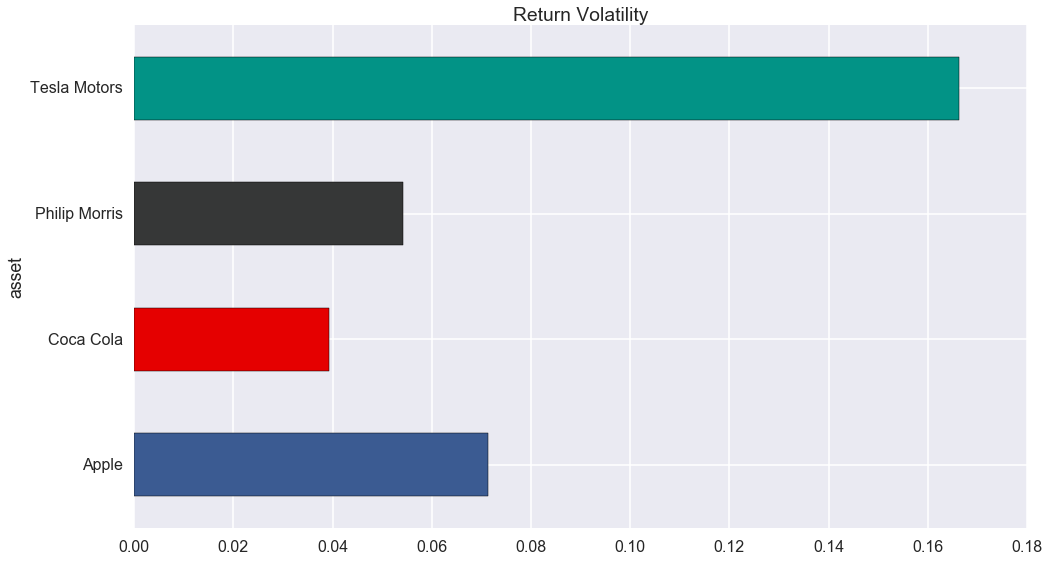

In [287]:
data.groupby('asset')['ret'].std().plot(kind='barh', figsize=FS, color=stock_colors)
_ = plt.title('Return Volatility')

<br/><br/><br/>

## Sharpe Ratio
When evaluating an investment opportunity, an investor is mainly interested in the trade-off between expected return and risk. 
Therefore, a widely used metric in finance is the **Sharpe Ratio**, which is defined as

$$ S(R) = \frac{ E(R) - r_f} {\sigma(R)} $$

Here $r_f$ is the risk-free rate. In the following we will ignore it, since nowadays it is practically zero.

In [288]:
def plot_sharpe(data, colors=stock_colors):
    df = data.groupby('asset')['ret'].agg( {'ret':[np.mean, np.std]} )
    df['Sharpe'] = df['ret','mean'] / df['ret','std']
    #df.sort_values('Sharpe', inplace=1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=FSS)
    df['ret'   ].plot( kind='barh', ax=ax1, color=['b','orange'] )
    df['Sharpe'].plot( kind='bar' , ax=ax2, color=colors, rot=20, label='Sharpe Ratio')
    _ = ax2.legend(loc=0)


In [316]:
df = data.groupby('asset')['ret'].agg( {'ret':[np.mean, np.std]} )
df['Sharpe'] = df['ret','mean'] / df['ret','std']
df

ret        Sharpe
                mean    std       
asset                             
Apple         0.0175 0.0714 0.2452
Coca Cola     0.0076 0.0393 0.1946
Philip Morris 0.0119 0.0542 0.2186
Tesla Motors  0.0488 0.1663 0.2932

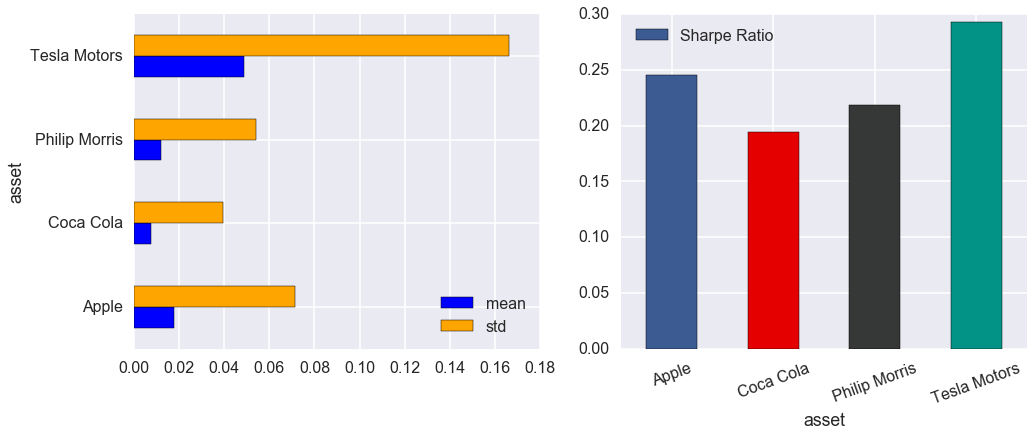

In [290]:
plot_sharpe(data)

<br/><br/><br/>

## Covariance and Correlation
The **covariance** between two random variables $X$ and $Y$ is defined as

$$ Cov(X,Y) = E(XY) - E(X)E(Y) $$
<br/><br/>
The **correlation** coefficient is a normalized version of the covariance:

$$ Corr(X,Y) = \frac{Cov(X,Y)}{\sigma(X)\sigma(Y)} \in (-1, 1) $$
<br/>
The correlation ( often denoted by $\rho$ ) measures the likelihood that $X$ and $Y$ will *move in the same direction* ( $\rho>0$ ) or in the *opposite direction* ( $\rho<0$ )

In [317]:
df = pd.DataFrame( )
for stock in all_stocks:
    df[stock.name] = data[stock.mask].set_index('date')['ret']
print( 'Correlation Matrix:' )
df.corr()

Correlation Matrix:


,Apple,Coca Cola,Philip Morris,Tesla Motors
Apple,1.0000,0.2456,0.3365,0.0137
Coca Cola,0.2456,1.0000,0.5747,-0.0918
Philip Morris,0.3365,0.5747,1.0000,0.0584
Tesla Motors,0.0137,-0.0918,0.0584,1.0000


<br/>
Our companies are far from being 100% correlated. There is room for diversification!

In particular, Tesla has a very low correlation with the other companies.

<br/><br/><br/>

## Diversification

Diversification is a key concept in finance.
An investor can mitigate the risk by forming a well-diversified portfolio with multiple stocks.
The less these stocks are correlated, the more the portfolio is diversified.

We now form an equally-weighted portfolio with our 4 stocks.
This means that we invest 25% of our capital in each company.

We can write down the return of our portfolio as

$$ R_P = \frac{R_1}{4} + \frac{R_2}{4} + \frac{R_3}{4} + \frac{R_4}{4} $$

In [292]:
pf = pd.DataFrame( )
pf['ret'] = data[all_stocks[0].mask].set_index('date')['ret'] * 0.25
for stock in all_stocks[1:]:
    pf['ret'] = pf['ret'] + data[stock.mask].set_index('date')['ret'] * 0.25    
pf['asset' ] = 'Diversified Portfolio'
pf['permno'] = 1

data_pf = data.append( pf.reset_index() )

Portfolio        = Stock( 1, 'purple', data=data_pf )

all_stocks_pf    = [ Apple, CocaCola, Portfolio, PhilipMorris, Tesla ]
stock_colors_pf  = [ x.color for x in all_stocks_pf ]

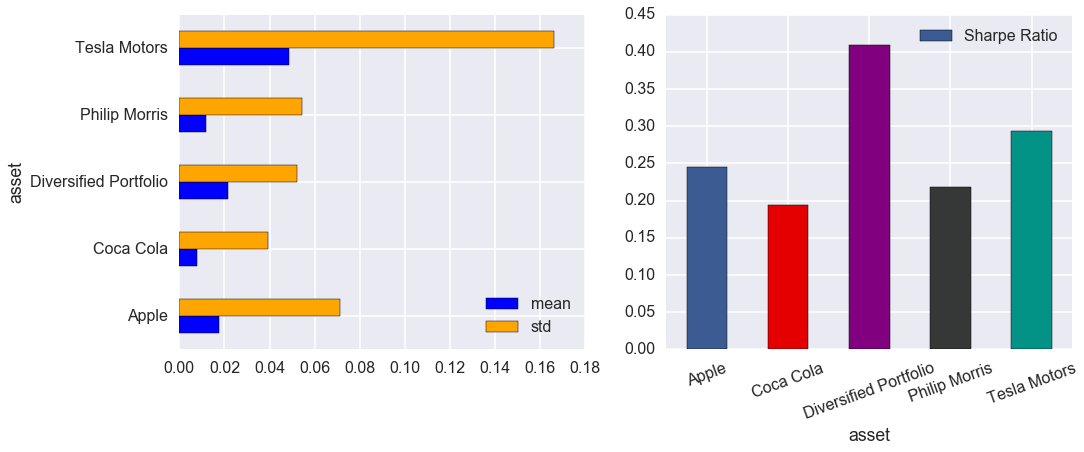

In [293]:
plot_sharpe(data_pf, colors=stock_colors_pf)

Our diversified porfolio offers a significantly higher Sharpe ratio than any single asset.

This is the power of diversification!

## The Mathematics of Diversification
$$ V(aX + bY) = a^2 V(X) + b^2 V(Y) + 2ab Cov(X,Y) $$

<br/><br/><br/>

In [294]:
def plot_cumulative(stocks, data=data):
    if type(stocks) == Stock:
        stocks = [stocks]
    fig, (ax1) = plt.subplots(1,1, figsize=FS)
    for stock in stocks:
        df = data[ data['permno']==stock.permno ].set_index('date').copy()
        df['ER' ] = df['ret'].mean()
        df['ret'].cumsum().plot(ax=ax1, label=stock.name +' Cumulative Return', color=stock.color)
        df['ER' ].cumsum().plot(ax=ax1, label=stock.name +' Expected Cumulative Return', style=':', color=stock.color)
    #ax1.set_ylim([-0.5, 3.5])

    legend = plt.legend(frameon=True, loc=2)
    frame = legend.get_frame()
    frame.set_facecolor('white')

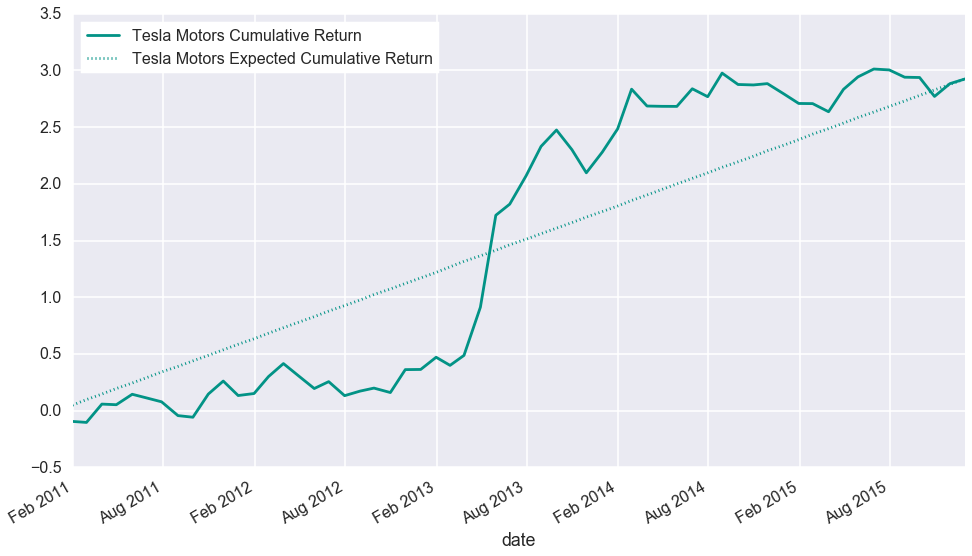

In [295]:
plot_cumulative( Tesla )

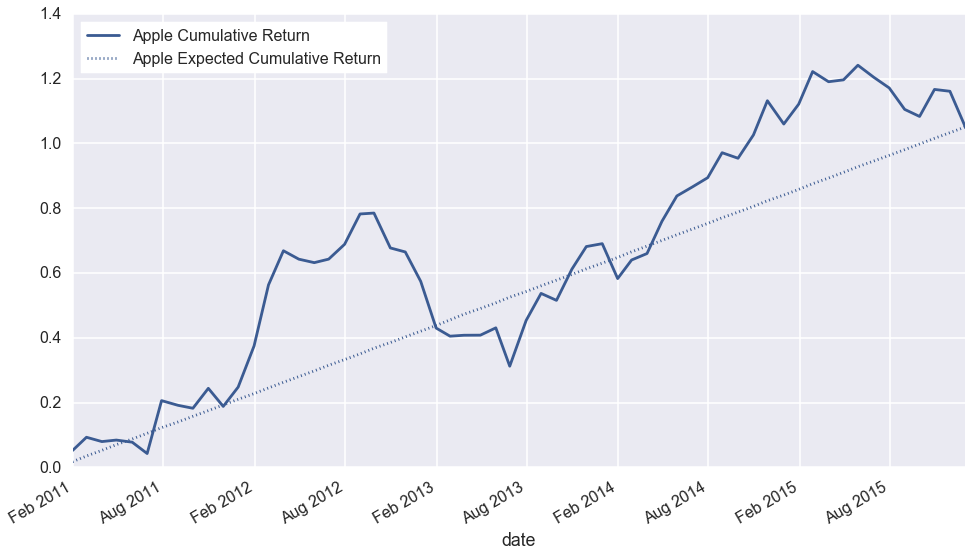

In [296]:
plot_cumulative( Apple )

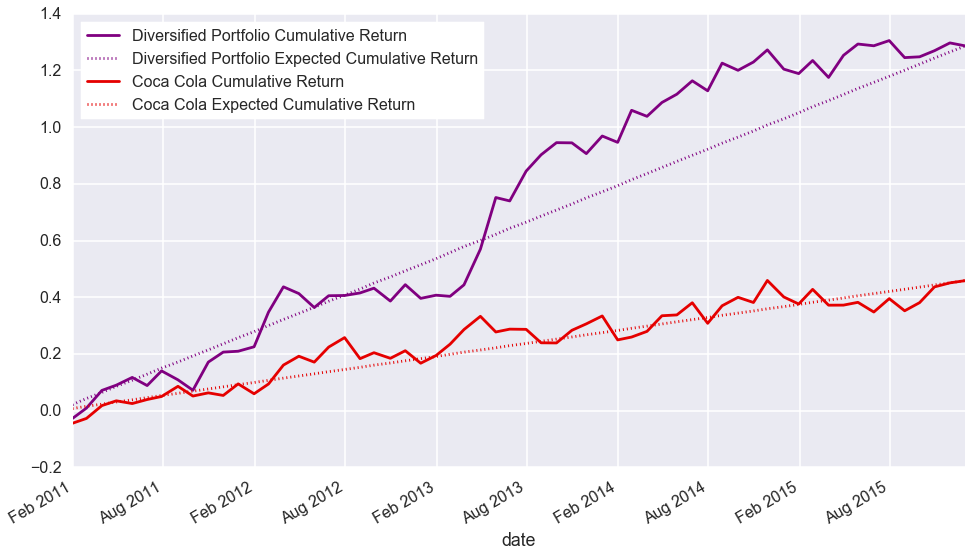

In [299]:
plot_cumulative( [Portfolio, CocaCola], data=data_pf )

<br/><br/><br/>